This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


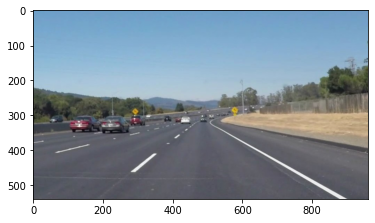

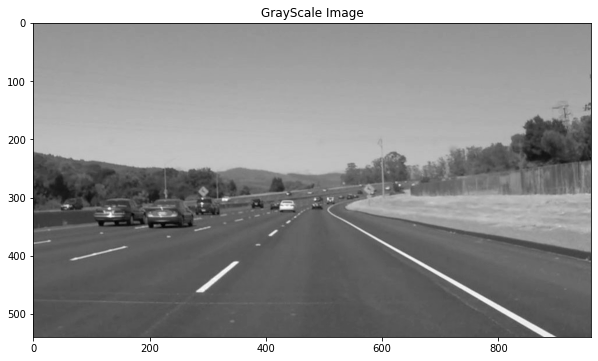

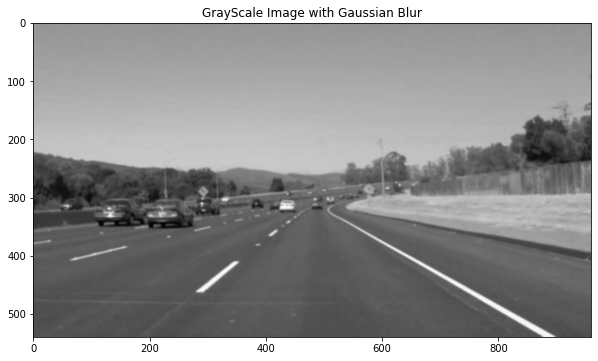

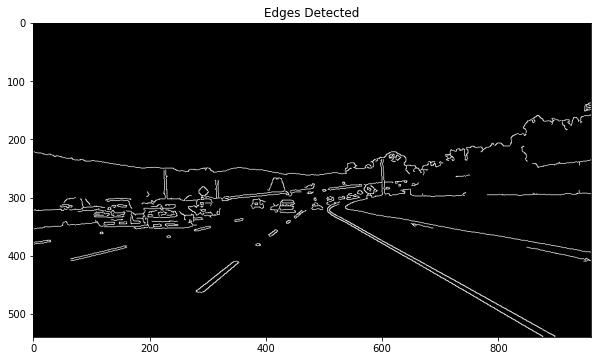

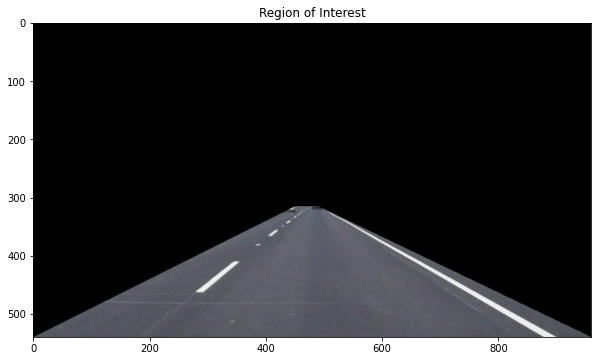

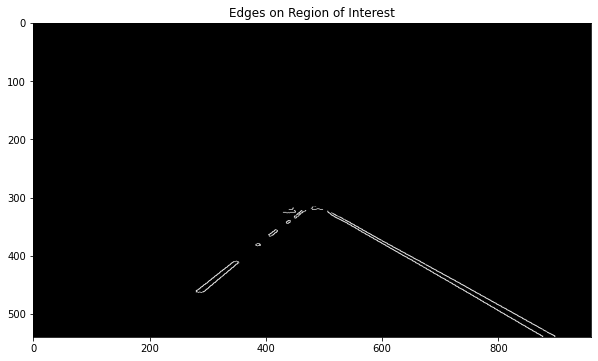

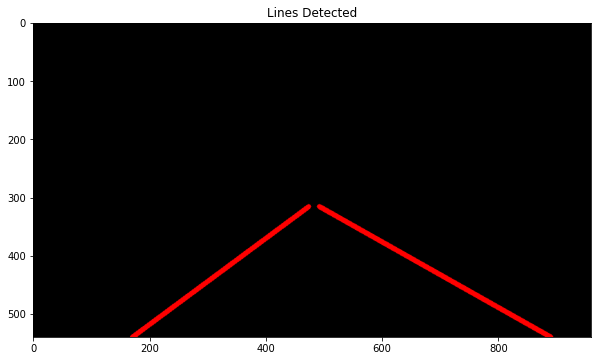

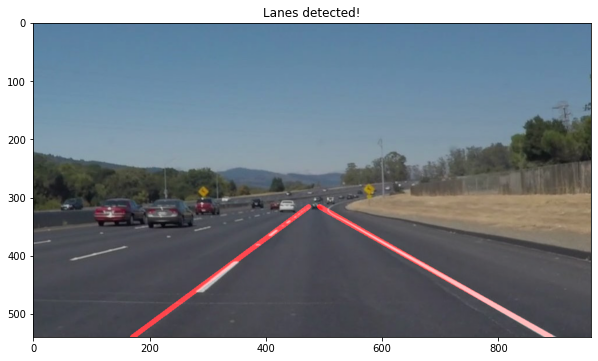

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('/content/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
   
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

            
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    
     #list to get positives and negatives values
    
    x_bottom_pos = []
    x_upperr_pos = []
    x_bottom_neg = []
    x_upperr_neg = []
    
    y_bottom = 540
    y_upperr = 315
    
    #y1 = slope*x1 + b
    #b = y1 - slope*x1 
    #y = slope*x + b
    #x = (y - b)/slope
    
    slope = 0
    b = 0
    
    #get x upper and bottom to lines with slope positive and negative    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #test and filter values to slope
            if ((y2-y1)/(x2-x1)) > 0.5 and ((y2-y1)/(x2-x1)) < 0.8 :
                
                slope = ((y2-y1)/(x2-x1))
                b = y1 - slope*x1
                
                x_bottom_pos.append((y_bottom - b)/slope)
                x_upperr_pos.append((y_upperr - b)/slope)
                                      
            elif ((y2-y1)/(x2-x1)) < -0.5 and ((y2-y1)/(x2-x1)) > -0.8:
            
                slope = ((y2-y1)/(x2-x1))
                b = y1 - slope*x1
                
                x_bottom_neg.append((y_bottom - b)/slope)
                x_upperr_neg.append((y_upperr - b)/slope)
                
               
    #creating a new 2d array with means
    lines_mean = np.array([[int(np.mean(x_bottom_pos)), int(np.mean(y_bottom)), int(np.mean(x_upperr_pos)), int(np.mean(y_upperr))],
                           [int(np.mean(x_bottom_neg)), int(np.mean(y_bottom)), int(np.mean(x_upperr_neg)), int(np.mean(y_upperr))]])
    
    
    #Drawing the lines
    for i in range(len(lines_mean)):
        cv2.line(img, (lines_mean[i,0], lines_mean[i,1]), (lines_mean[i,2], lines_mean[i,3]), color, thickness)
                    
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
   
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

import os
os.listdir("/content/Test")

gray = grayscale(image)
plt.figure(figsize=(10,7))
plt.title("GrayScale Image")
plt.imshow(gray, cmap='gray')

kernel_size = 5 # Kernel size
blur_gray = gaussian_blur(gray, kernel_size)
plt.figure(figsize=(10,7))
plt.title("GrayScale Image with Gaussian Blur")
plt.imshow(blur_gray, cmap='gray')

low_threshold = 50
high_threshold = 150

slice1Copy = np.uint8(blur_gray)
edges = canny(slice1Copy, low_threshold, high_threshold)
plt.figure(figsize=(10,7))
plt.title("Edges Detected")
plt.imshow(edges, cmap='Greys_r')

vertices = np.array([[(0,image.shape[0]),(450, 315), (490, 315), 
                          (image.shape[1],image.shape[0])]], dtype=np.int32)
mask = region_of_interest(image, vertices)
plt.figure(figsize=(10,7))
plt.title("Region of Interest")
plt.imshow(mask, cmap='Greys_r')

masked_edges = region_of_interest(edges, vertices)
plt.figure(figsize=(10,7))
plt.title("Edges on Region of Interest")
plt.imshow(masked_edges, cmap='Greys_r')

rho = 3
theta = np.pi/180
threshold = 15
min_line_len = 150
max_line_gap = 50

lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

plt.figure(figsize=(10,7))
plt.title("Lines Detected")
plt.imshow(lines)

lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)

plt.figure(figsize=(10,7))
plt.title("Lanes detected!")
plt.imshow(lines_edges)
